# Formal concept analysis

We apply FCA to Wikivitals to find relevant set of words (= concepts) shared by groups of articles.

## Import

In [719]:
import numpy as np
from scipy import sparse, special

In [2]:
from sknetwork.data import load_netset
from sknetwork.utils import get_degrees, get_membership
from sknetwork.ranking import top_k
from sknetwork.topology import Triangles, Cliques

## Data


In [351]:
wikivitals = load_netset('wikivitals+')

Parsing files...
Done.


In [352]:
adjacency = wikivitals.adjacency
biadjacency = wikivitals.biadjacency
names = wikivitals.names
words = wikivitals.names_col
labels = wikivitals.labels

In [353]:
biadjacency

<45179x85512 sparse matrix of type '<class 'numpy.int64'>'
	with 4786126 stored elements in Compressed Sparse Row format>

In [354]:
indexes = biadjacency[0].indices[:2]
words[indexes], indexes

(array(['mixture', 'directly'], dtype='<U26'),
 array([ 616, 4060], dtype=int32))

In [355]:
bool_biadj = biadjacency.astype(bool)
obj = np.flatnonzero(bool_biadj[:, indexes].dot(np.ones(len(indexes))) == len(indexes))
names[obj]

array([' Law of mass action', 'Diesel engine', 'Fructose', 'Lidocaine',
       'Lithography', 'Matthew Quintal', 'Ned Young', 'Oil shale',
       'Reaction intermediate', 'Sand casting', 'Soft drink',
       'Solubility', 'Vermicompost', 'William McCoy (mutineer)'],
      dtype='<U85')

## Interest of concept  

> "An event is unexpected if it is simpler (=less complex) to describe than to generate." (Simplicity theory)

- unexpectedness $U = C_w - C$, with $C_w$ the complexity to generate situation and $C$ the description complexity
- here complexity is the minimal description
- we can compute amount of information received for each subset of attributes in $A$, $I(X)=\text{log}_2(\dfrac{1}{\prod_i p_i(x)})$, with $X \subseteq A$ and $x \in X$  
- description complexity

In [8]:
corpus = ['the', 'brown', 'fox', 'the', 'eat', 'brown', 'dog', 'the', 'the', 'the', 'the',
         'dog', 'the', 'the', 'the', 'the', 'blue', 'blue', 'the', 'eat', 'brown', 'cat', 'blue', 'blue', 'blue', 'blue']
words, counts = np.unique(corpus, return_counts=True)
words, counts

(array(['blue', 'brown', 'cat', 'dog', 'eat', 'fox', 'the'], dtype='<U5'),
 array([ 6,  3,  1,  2,  2,  1, 11]))

In [9]:
d = {}
for i, j in zip(words, counts):
    d[i]=j
d

{'blue': 6, 'brown': 3, 'cat': 1, 'dog': 2, 'eat': 2, 'fox': 1, 'the': 11}

In [27]:
def gen_complexity(N, k):
    """Complexity of selecting k among N elements"""
    return np.log2(special.comb(N, k))

def desc_complexity(probs):
    res = 1
    for i in probs:
        res *= i
    return res * np.log2(1 / (res))


res_vals = {}
combs = []
cpt = 0
N = np.sum(counts)
cw = gen_complexity(len(d), 2)
print(cw)
print()
for i in range(20):
    ws = np.random.choice(words, 2)
    res = 1
    if len(np.unique(ws)) > 1:
        for w in ws:
            res *= d.get(w) / N
    else:
        res = d.get(ws[0]) / N
    c = desc_complexity([res])
    u = cw - c
    print(f'words: {ws} - c: {c:.3f} - u: {(cw - c):.5f}')
    if tuple(ws) not in combs:
        combs.append(tuple(ws))
        res_vals[cpt] = u
        cpt += 1
        
sorted_list = sorted(res_vals.items(), key=lambda x: x[1], reverse=True)
for idx, t in enumerate(sorted_list):
    if idx < 5:
        print(combs[t[0]], t[1])

4.392317422778761

words: ['eat' 'the'] - c: 0.161 - u: 4.23150
words: ['eat' 'cat'] - c: 0.025 - u: 4.36746
words: ['blue' 'brown'] - c: 0.139 - u: 4.25303
words: ['fox' 'dog'] - c: 0.025 - u: 4.36746
words: ['cat' 'dog'] - c: 0.025 - u: 4.36746
words: ['blue' 'dog'] - c: 0.103 - u: 4.28908
words: ['eat' 'cat'] - c: 0.025 - u: 4.36746
words: ['cat' 'dog'] - c: 0.025 - u: 4.36746
words: ['fox' 'cat'] - c: 0.014 - u: 4.37841
words: ['eat' 'eat'] - c: 0.285 - u: 4.10767
words: ['eat' 'eat'] - c: 0.285 - u: 4.10767
words: ['brown' 'brown'] - c: 0.359 - u: 4.03284
words: ['cat' 'fox'] - c: 0.014 - u: 4.37841
words: ['blue' 'brown'] - c: 0.139 - u: 4.25303
words: ['eat' 'cat'] - c: 0.025 - u: 4.36746
words: ['fox' 'fox'] - c: 0.181 - u: 4.21153
words: ['dog' 'cat'] - c: 0.025 - u: 4.36746
words: ['fox' 'blue'] - c: 0.060 - u: 4.33182
words: ['eat' 'fox'] - c: 0.025 - u: 4.36746
words: ['blue' 'blue'] - c: 0.488 - u: 3.90413
('fox', 'cat') 4.3784107963937275
('cat', 'fox') 4.3784107963937275

---
$L(M) = L(G) + L(A)$  


*Source:* https://www.jair.org/index.php/jair/article/view/10113/23946

The encoding of a subgraph $G$ is the number of bits to encode its numbered vertices (we do not take into account labels as their number stand for their label), as well as the number of bits to encode each row in the adjacency matrix, i.e edge encoding.  

$L(nodes) = log(|V|)$   
$L(rows) = log(b+1) + \sum_{v \in V}log(b+1) + log(\binom{|V|}{k_v})$, $b = max_{v \in V}(deg(v))$, $k$ is the number of non zero elements in row  
$L(G) = l(nodes) + L(rows)$

We succeed in findings the most unexpected sets of attributes

**Algorithm?**  
Etant donné un graphe attribué $G=(V, E, A)$
- démarrer à partir d'un sous graphe $g_0$ (lequel? k-core, connected compo, clique ...)
- ajouter des noeuds $v \in V$ 1 à 1 et
    - calculer la closure, i.e le sous ensemble d'attributes, des noeuds du sous-graphe constitué $V(g_i)^{\prime}=X \in A$
    - calculer la surprise (unexpedctness $U$) de cette closure $U(X)$. $U$ peut etre calculé en utilisant les fréquences d'apparition des attributs dans X.
    - si la surprise augmente avec le noeud ajouté, on le garde. Sinon on cherche un autre noeud.

- set of candidate attributes $C$
- for $a \in C$
    - compute closure $a'$ to select all corresponding objects $o$
    - filter objects $f(o)$ that are in a $k$-core (with $k>d$)
    - if $|f{o}|$ has not changed $\rightarrow$ break
    - else compute closure $f(o)'$ to get closed set of attribute candidates
        - if $U_{prec}(f(o), f(o)') - U(f(o), f(o)') < \alpha$ $\rightarrow$ no additional interesting information, break (with $U$ unexpectedness of event)
        - else algo()



In [440]:
from scipy import special

def mdl_graph(adjacency):
    n = adjacency.shape[0]

    # density
    d = np.sum(adjacency) / (n * (n - 1))
    
    # nodes
    nodes_mdl = np.log2(n)
    
    # edges
    degrees = adjacency.dot(np.ones(n))
    max_degree = np.max(degrees)
    edges_mdl = (n + 1) * np.log2(max_degree + 1) + np.sum([np.log2(special.comb(n, deg)) for deg in degrees])

    return (nodes_mdl + edges_mdl)

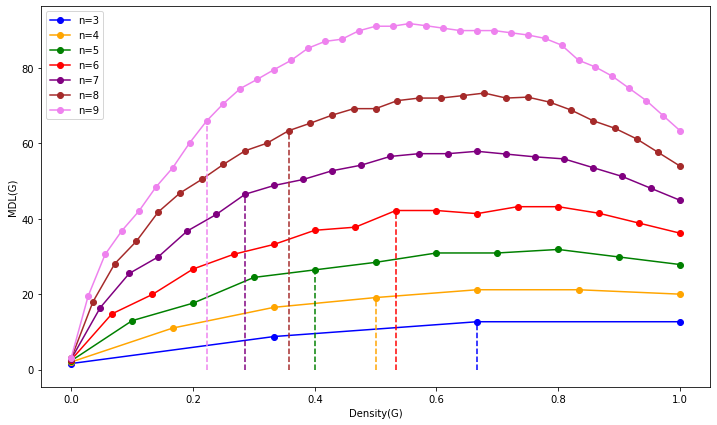

In [774]:
from itertools import combinations
from sknetwork.topology import is_connected

fig, ax = plt.subplots(1, 1, figsize=(12, 7))
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'violet']
conns = []
sizes = np.arange(3, 10)
for i, k in enumerate(sizes):
    plotted = False
    n = k

    edges = list(combinations(range(n), 2))
    A = np.zeros((n, n))

    dens = [0]
    mdls = [mdl_graph(A)]

    while len(edges) > 0:
        idx = np.random.choice(len(edges), 1)[0]
        A[edges[idx]] = 1
        A[tuple(reversed(edges[idx]))] = 1
        m = A.sum()
        density = ( m) / (n * (n - 1))
        dens.append(density)
        mdl = mdl_graph(A)
        mdls.append(mdl)
        edges.pop(idx)
        conn = is_connected(A)
        conns.append(conn)
        if conn and not plotted:
            plt.vlines(x=density, ymin=0, ymax=mdl, color=colors[i], linestyle='--')
            plotted = True

    plt.plot(dens, mdls, marker='o', label=f'n={n}', color=colors[i])
    plt.xlabel('Density(G)')
    plt.ylabel('MDL(G)')
    plt.legend();

In [844]:
from random import random
from sknetwork.data import from_edge_list

def random_graph(n, p):
    edges = []
    lp = np.log(1 - p)
    v = 1
    w = -1
    while v < n:
        lr = np.log(1 - random())
        w = w + 1 + int(lr / lp)
        while w >= v and v < n:
            w = w - v
            v = v + 1
        if v < n:
            edges.append((w, v))
    
    v = 1
    w = -1   
    while v < n:
        lr = np.log(1 - random())
        w = w + 1 + int(lr / lp)
        while w >= v and v < n:
            w = w - v
            v = v + 1
        if v < n:
            edges.append((v, w))
    g = from_edge_list(edges, directed=True, matrix_only=True)

    return g

g = random_graph(10, 0.2)

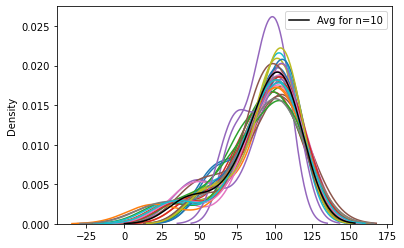

In [897]:
res = []
for j in range(30):
    tmp = []
    for i in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        tmp.append(mdl_graph(random_graph(10, i)))
    #plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], tmp)
    res += tmp
    sns.kdeplot(tmp)
av = np.mean(np.array(res).reshape(30, 9), axis=0)
sns.kdeplot(av, color='black', label='Avg for n=10')
plt.legend();

In [464]:
def mdl_attr(attrs, occurences):
    """Minimum Description Length of a set of attributes w.r.t their number of occurences in vocabulary.
    
    Parameters
    ----------
    attrs : np.ndarray
        Array of attribute indexes
    occurences : sparse.csr_matrix
        Sparse matrix with number of occurences of each attribute, with shape (n, m), with n the number of objects and m the number of attributes
    """
    n, m = occurences.shape
    degrees = occurences.T.dot(np.ones(n))
    total_count = degrees.sum()
    
    # Probabilities of occurence of attributes
    probs = degrees[attrs] / total_count
    prob = np.prod(probs)
    
    # MDL
    mdl = prob * np.log2(1 / prob)
    
    return mdl

Cw of attribute set of size 5: 75.01 bits


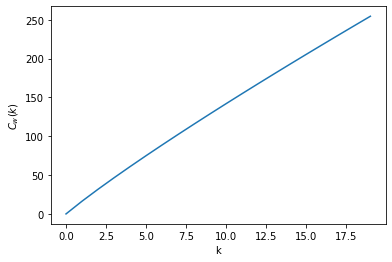

In [465]:
# Random set of attributes
def generation_complexity(N, k):
    return np.log2(special.comb(N, k))

k = 5
gen_compl = generation_complexity(biadjacency.shape[1], k)
print(f'Cw of attribute set of size {k}: {gen_compl:.2f} bits')

res = []
for i in range(20):
    res.append(np.log2(special.comb(biadjacency.shape[1], i)))
plt.plot(np.arange(0, 20), res)
plt.xlabel('k')
plt.ylabel('$C_{w}(k)$');

In [483]:
# Random set of attributes
attrs = np.random.randint(0, len(words), size=5)
print(attrs)
print(f'MDL of {words[attrs]}: {mdl_attr(attrs, biadjacency)}')
print(gen_compl - mdl_attr(attrs, biadjacency))

[23285 14725 78684 20777 34248]
MDL of ['Sodom' 'Buruma' 'Βασιλείου' 'gyrfalcon' 'Bade']: 4.644524455187911e-31
75.01213703312109


In [480]:
# Random set of attributes
attrs = top_k(biadjacency.T.dot(np.ones(biadjacency.shape[0])), 5)
print(attrs)
print(f'MDL of {words[attrs]}: {mdl_attr(attrs, biadjacency)}')
print(gen_compl - mdl_attr(attrs, biadjacency))

[85396 65226 57156 29997 48204]
MDL of ['the' 'of' 'be' 'and' 'in']: 2.9961354039515684e-06
75.01213403698569


In [475]:
degrees = biadjacency.T.dot(np.ones(biadjacency.shape[0]))

In [476]:
np.log2(special.comb(biadjacency.shape[1], 1)) * (-np.log2(degrees[42266] / np.sum(degrees)))

308.60552148357766

In [539]:
print('Random selection of 1 item: ', np.log2(special.comb(biadjacency.shape[1], 1))) # Select 1 among N -> = log2(N)
#print('Random selection of 1 item: ', np.log2(special.comb(biadjacency.shape[1], 1))) # Select 1 among N -> = log2(N)
print('word: CAD: ', (-np.log2(degrees[42266] / np.sum(degrees)))) # select 1 specific item with proba x among M
print('word: the: ', (-np.log2(degrees[85396] / np.sum(degrees)))) # select 1 specific item with proba x among M
print('word: of: ', (-np.log2(degrees[65226] / np.sum(degrees)))) # select 1 specific item with proba x among M
print('word: be: ', (-np.log2(degrees[57156] / np.sum(degrees)))) # select 1 specific item with proba x among M
print('word: Βασιλείου: ', (-np.log2(degrees[78684] / np.sum(degrees)))) # select 1 specific item with proba x among M

Random selection of 1 item:  16.383839268854455
word: CAD:  18.83597100895846
word: the:  3.694649517066012
word: of:  4.531360751412513
word: be:  4.758755597525299
word: Βασιλείου:  22.083898522402045


In [610]:
def entropy(prob):
    return prob * -np.log2(prob)

def desc_complexity(attrs):
    if isinstance(attrs, int):
        attrs = [attrs]
    prob = 1
    for attr in attrs:
        prob *= degrees[attr] / np.sum(degrees)
    entr = entropy(prob)
    return generation_complexity(biadjacency.shape[1], len(attrs)) * entr
        
print(f'C(the) = {desc_complexity(85396)}') #the
print('C(CAD) =', desc_complexity(42266)) #CAD
print('C(Βασιλείου) =', desc_complexity(78684)) #Βασιλείου

print()
print(f"C({{the, CAD}}) ={desc_complexity([85396, 42266]):.6f}")
print(f"C({{the, Βασιλείου}}) ={desc_complexity([85396, 78684]):.6f}")
print(f"C({{CAD, Βασιλείου}}) ={desc_complexity([42266, 78684]):.6f}")

print()
print(f"C({{the, CAD, be}}) ={desc_complexity([85396, 42266, 57156]):.6f}")

C(the) = 4.675075158289114
C(CAD) = 0.0006594948688775455
C(Βασιλείου) = 8.139084271209067e-05

C({the, CAD}) =0.000118
C({the, Βασιλείου}) =0.000014
C({CAD, Βασιλείου}) =0.000000

C({the, CAD, be}) =0.000008


In [612]:
np.log2(special.comb(biadjacency.shape[1], 2))

31.767661666351948

In [ ]:
print('word: CAD: ', (-np.log2(degrees[42266] / np.sum(degrees)))) # select 1 specific item with proba x among M
print('word: the: ', (-np.log2(degrees[85396] / np.sum(degrees)))) # select 1 specific item with proba x among M

In [614]:
print(-np.log2(50/52))
print(-np.log2(2/52))

0.056583528366367424
4.700439718141092


In [630]:
print(np.log2(biadjacency.shape[1]) + np.log2(degrees[42266] / biadjacency.shape[1]))
print(np.log2(biadjacency.shape[1]) + np.log2(degrees[85396] / biadjacency.shape[1]))

4.247927513443585
19.389249005336033


In [633]:
np.log2(degrees[42266])

4.247927513443585

In [634]:
np.log2(degrees[85396])

19.389249005336033

In [636]:
np.log2(special.comb(biadjacency.shape[1], 1)) * 

16.383839268854455

In [655]:
print(np.log2(len(degrees[degrees <= degrees[42266]])))
print(np.log2(len(degrees[degrees <= degrees[85396]])))
print(np.log2(len(degrees[degrees <= degrees[1]])))

15.998546358475881
16.383839268854455
14.153472864970588


In [668]:
print(np.log2(special.comb(biadjacency.shape[1], 3)))
print(np.log2(len(degrees[degrees <= degrees[42266]])) + np.log2(len(degrees[degrees <= degrees[85396]])))
print(np.log2(len(degrees[degrees <= degrees[1]])) + np.log2(len(degrees[degrees <= degrees[1]])) + np.log2(len(degrees[degrees <= degrees[1]])))

46.56650469157402
32.382385627330336
42.460418594911765


On sélectionne un mot dans le vocabulaire. La complexité est calculée comme le nombre de bits nécessaire pour distinguer ce mot parmis tous les mots de même degré.

In [681]:
np.log2(np.sum(degrees))

23.083898522402045

In [688]:
print(np.log2(np.sum(degrees)/len(degrees[degrees == degrees[1]])))
print(np.log2(np.sum(degrees)/len(degrees[degrees == degrees[42266]])))
print(np.log2(np.sum(degrees)/len(degrees[degrees == degrees[85396]])))

8.930425657431458
13.61425670516253
23.083898522402045


In [689]:
np.log2(np.max(degrees))

19.389249005336033

In [699]:
print(1/np.log2(1/(degrees[85396] / np.sum(degrees))))
print(1/-np.log2(degrees[42266] / np.sum(degrees)))
print(1/-np.log2(degrees[1] / np.sum(degrees)))

0.2706616677389519
0.05308990970119864
0.045281859948124364


In [704]:
print(np.log2(np.max(degrees)))
print(np.log2(degrees[85396]))
print(np.log2(degrees[42266]))
print(np.log2(degrees[1]))

19.389249005336033
19.389249005336033
4.247927513443585
1.0


In [707]:
np.log2(2+1000)

9.968666793195208

In [714]:
degs = biadjacency.astype(bool).T.dot(np.ones(biadjacency.shape[0]))
degs[85396]

44253.0

In [736]:
print(np.log2(special.comb(biadjacency.shape[1], 1)))
print(np.log2(degs[85396]))
print(np.log2(degs[42266]))
print(np.log2(degs[1]))

16.383839268854455
15.433487641262927
3.9068905956085187
1.0


In [769]:
# U for 1 attribute
cw = np.log2(special.comb(biadjacency.shape[1], 1))
for attr in [85396, 42266, 78684, 1]:
    c = np.log2(degs[attr])
    print(f'{words[attr]:<8}: c={c:<8.3f} u={(cw-c):.3f}')
    
print()
# U for 2 attribute
sets = []
cw = np.log2(special.comb(biadjacency.shape[1], 2))
for attr in [85396, 42266, 78684, 1]:
    for attr2 in [85396, 42266, 78684, 1]:
        s = set([attr, attr2])
        if attr != attr2 and s not in sets:
            sets.append(s)
            c = np.log2(degs[attr]) + np.log2(degs[attr2])
            print(f'{{{words[attr]},{words[attr2]}}}: c={c:<8.3f} u={(cw-c):.3f}')
            
print()
# U for 2 attribute
sets = []
cw = np.log2(special.comb(biadjacency.shape[1], 3))
for attr in [85396, 42266, 78684, 1]:
    for attr2 in [85396, 42266, 78684, 1]:
        for attr3 in [85396, 42266, 78684, 1]:
            s = set([attr, attr2, attr3])
            if s not in sets and len(s) == 3:
                sets.append(s)
                c = np.log2(degs[attr]) + np.log2(degs[attr2]) + np.log2(degs[attr3])
                print(f'{{{str(words[list(s)]):<30}}}: c={c:<8.3f} u={(cw-c):.3f}')

the     : c=15.433   u=0.950
CAD     : c=3.907    u=12.477
Βασιλείου: c=1.000    u=15.384
Copan   : c=1.000    u=15.384

{the,CAD}: c=19.340   u=12.427
{the,Βασιλείου}: c=16.433   u=15.334
{the,Copan}: c=16.433   u=15.334
{CAD,Βασιλείου}: c=4.907    u=26.861
{CAD,Copan}: c=4.907    u=26.861
{Βασιλείου,Copan}: c=2.000    u=29.768

{['CAD' 'the' 'Βασιλείου']     }: c=20.340   u=26.226
{['Copan' 'CAD' 'the']         }: c=20.340   u=26.226
{['Copan' 'the' 'Βασιλείου']   }: c=17.433   u=29.133
{['Copan' 'CAD' 'Βασιλείου']   }: c=5.907    u=40.660


We compute the description complexity of a set of attributes, as the minimal description length to describe the set of corresponding objects w.r.t the set of attributes :  
$$
L(X)=\sum_{a \in X}\text{log}_2 (d_{G}(a)), \text{ with } X \subseteq A
$$  
In other words, $L(X)$ measures the cost to single out objects sharing characteristic $X \subseteq A$. This cost is related to the degree of the elements in $X$, i.e their number of occurences. Indeed, a very common attribute such as $\texttt{the}$ will have a high degree (will be shared by a large amount of objects), and the complexity to single out objects sharing this attribute will be high. On the other side, an attribute such as $\texttt{Βασιλείου}$ will have a small degree, and it will be easier to describe the event among all possible ones (i.e less complex).

## FCA

In [8]:
context = biadjacency > 0

In [9]:
context

<45179x85512 sparse matrix of type '<class 'numpy.bool_'>'
	with 4786126 stored elements in Compressed Sparse Row format>

In [10]:
def get_concepts(context, n_concepts = 5000, n_objects_max = 1000, n_objects_min = 10, depth = 5):
    """Get concepts by FCA.
    
    Parameters
    ----------
    context : sparse matrix
        Matrix object x attribute.
    n_concepts : int
        Maximum number of concepts per level (except top level).
    n_objects_max : int
        Maximum number of objects per attribute (frequent attributes are discarded).
    n_objects_min : int
        Minimum number of objects per attribute (rare attributes are discarded).
    depth : int
        Depth of the hierarchy
        
    Returns
    -------
    index_attribute : np.ndarray
        Index of attributes.
    concept_attribute : sparse matrix
        Matrix concept x attributes.
    concept_object : sparse matrix
        Matrix concept x object.
    """
    n_objects, n_attributes = context.shape

    # select attributes
    freq_attribute = get_degrees(context, transpose=True)
    index = np.flatnonzero((freq_attribute <= n_objects_max) & (freq_attribute >= n_objects_min))
    attribute = sparse.identity(n_attributes).tocsr()[index]
    n_attributes = len(index)
    concept_attribute = sparse.identity(n_attributes).tocsr()
    concept_object = context.T.tocsr()[index]
    freq_attribute = freq_attribute[index]
    index_attribute = index.copy()
    
    # simple concepts (= single attribute)
    simple_concept_attribute = concept_attribute.copy()
    simple_concept_object = concept_object.copy()
    simple_concept_freq = freq_attribute.copy()

    # current concepts (= simple concepts to start)
    current_concept_attribute = concept_attribute.copy()
    current_concept_object = concept_object.copy()
    current_concept_freq = freq_attribute.copy()

    for t in range(1, depth):

        # add attribute
        concept_count = current_concept_object.astype(int).dot(simple_concept_object.T).tocoo()
        row = concept_count.row
        col = concept_count.col
        count = concept_count.data

        # score concepts
        scores = np.minimum(current_concept_freq[row] - count, simple_concept_freq[col] - count)
        scores = np.minimum(scores, count)
        scores = scores * (scores >= n_objects_min)

        # select concepts
        index = top_k(scores, n_concepts)
        concept_attribute_ = sparse.lil_matrix((n_concepts, n_attributes), dtype=bool)
        concept_ids = current_concept_attribute[row[index]].indices
        attribute_ids = simple_concept_attribute[col[index]].indices
        row_ = np.repeat(np.arange(len(index)), t + 1)
        col_ = np.hstack((concept_ids.reshape(-1, t), attribute_ids.reshape(-1, 1))).ravel()
        concept_attribute_[row_, col_] = 1
        concept_attribute_ = concept_attribute_.tocsr()

        # remove duplicates
        _, index_ = np.unique(concept_attribute_.indices.reshape(-1, t + 1), axis=0, return_index=True)
        concept_attribute_ = concept_attribute_[index_]
        index = index[index_]

        # count objects
        concept_object_ = current_concept_object[row[index]].minimum(simple_concept_object[col[index]])
        concept_object_.eliminate_zeros()
        concept_freq_ = get_degrees(concept_object_)

        # update 
        concept_attribute = sparse.vstack((concept_attribute, concept_attribute_))
        concept_object = sparse.vstack((concept_object, concept_object_))

        current_concept_attribute = concept_attribute_.copy()
        current_concept_object = concept_object_.copy()
        current_concept_freq = concept_freq_.copy()
    
    return index_attribute, concept_attribute, concept_object

In [11]:
%%time
index_attribute, concept_attribute, concept_object = get_concepts(context)

CPU times: user 2.71 s, sys: 599 ms, total: 3.31 s
Wall time: 3.31 s


In [12]:
names_attribute = words[index_attribute]

In [13]:
concept_object

<36320x45179 sparse matrix of type '<class 'numpy.bool_'>'
	with 2679756 stored elements in Compressed Sparse Row format>

In [14]:
concept_attribute

<36320x24282 sparse matrix of type '<class 'numpy.float64'>'
	with 68148 stored elements in Compressed Sparse Row format>

## Display

In [48]:
concept_freq = get_degrees(concept_object)

In [49]:
length_concept = get_degrees(concept_attribute)

In [50]:
lengths, counts = np.unique(length_concept, return_counts=True)

In [51]:
print(counts)

[24282  2517  2784  3205  3532]


In [52]:
depth = max(lengths)

In [53]:
concept_attribute

<36320x24282 sparse matrix of type '<class 'numpy.float64'>'
	with 68148 stored elements in Compressed Sparse Row format>

In [54]:
# some concepts
for t in range(1, depth):
    length = t + 1
    print('-----')
    print('Length', length)
    index = np.flatnonzero(length_concept==length)
    for i in np.random.choice(index, size=10):
        print(names_attribute[concept_attribute[i].indices], concept_freq[i])

-----
Length 2
['port' 'metropolitan'] 128
['metropolitan' 'growth'] 92
['League' 'victory'] 94
['al' 'Ali'] 84
['sound' 'band'] 155
['studio' 'Billboard'] 143
['observation' 'observe'] 84
['Olympics' 'athlete'] 141
['astronomical' 'planet'] 87
['Ocean' 'settlement'] 86
-----
Length 3
['League' 'Champions' 'Cup'] 75
['tour' 'band' 'induct'] 78
['hit' 'Grammy' 'you'] 66
['Sciences' 'economist' 'Nobel'] 67
['hit' 'chart' 'songwriter'] 79
['UNESCO' 'populous' 'Heritage'] 64
['nomination' 'Film' 'accolade'] 58
['gold' 'retire' 'medal'] 84
['Olympics' 'bronze' 'medal'] 66
['Grammy' 'songwriter' 'induct'] 54
-----
Length 4
['symptom' 'risk' 'disease' 'factor'] 42
['album' 'Rock' 'induct' 'Music'] 51
['album' 'Roll' 'Rock' 'guitar'] 57
['sale' 'album' 'certify' 'Billboard'] 37
['album' 'pop' 'recording' 'songwriter'] 45
['hit' 'pop' 'Hot' 'Billboard'] 46
['album' 'Grammy' 'Top' 'Music'] 39
['symptom' 'medication' 'blood' 'diagnosis'] 38
['album' 'Records' 'tour' 'band'] 51
['album' 'studio' '

In [55]:
# a concept and its objects
for t in range(1, depth):
    length = t + 1
    print('-----')
    print('Length', length)
    index = np.flatnonzero(length_concept==length)
    i = np.random.choice(index)
    print(names_attribute[concept_attribute[i].indices], concept_freq[i])
    objects = concept_object[i].indices[:20]
    print(names[objects])

-----
Length 2
['hit' 'chart'] 200
['...Baby One More Time (song)' '2NE1' 'A-ha' 'ABBA' 'AC/DC'
 'Adult contemporary music' 'Aerosmith' 'Akon' 'Alabama (band)'
 'Alice in Chains' 'Alizée' 'All You Need Is Love' 'American Pie (song)'
 'Amy Grant' 'Andrea Bocelli' 'Anita Bryant' 'Are You Experienced'
 'Ayumi Hamasaki' 'Backstreet Boys' 'Bananarama']
-----
Length 3
['hit' 'studio' 'songwriter'] 64
['Akon' 'Anitta (singer)' 'Astral Weeks' 'Ayumi Hamasaki' 'Barry White'
 'Bette Midler' 'Beyoncé' 'Billie Eilish' 'Billy Joel' 'Blonde on Blonde'
 'Bob Marley' 'Brian Wilson' 'Bruce Springsteen' 'Bruno Mars'
 'Buddy Holly' 'Carrie Underwood' 'Cat Stevens'
 'Crosby, Stills, Nash & Young' 'Cyndi Lauper' 'Daddy Yankee']
-----
Length 4
['album' 'chart' 'Billboard' 'Top'] 56
['Akon' 'Alicia Keys' 'Are You Experienced' 'BTS' 'Bananarama'
 'Calvin Harris' 'Cardi B' 'Carly Simon' 'Carrie Underwood' 'Def Leppard'
 'Dolly Parton' 'Donna Summer' 'Donovan' 'Dusty Springfield'
 'Gloria Estefan' 'Imagine (Joh

In [56]:
# an object and its concepts
i = np.random.choice(concept_object.shape[1])
print(names[i])
print()
concepts = np.flatnonzero(concept_object[:, i].toarray().ravel() * (length_concept > 1))
if len(concepts) > 10:
    concepts = np.random.choice(concepts, size=10, replace=False)
for j in concepts:
    print(names_attribute[concept_attribute[j].indices], concept_freq[j])

Coat of arms of the Republic of Albania



In [57]:
concept_attribute

<36320x24282 sparse matrix of type '<class 'numpy.float64'>'
	with 68148 stored elements in Compressed Sparse Row format>

## New method

In [129]:
# Filter concept that have > 1 attribute inside their intent
concept_size = get_degrees(concept_attribute)
mask = concept_size > 1
big_concept_attribute = concept_attribute[mask]

In [130]:
big_concept_attribute

<12038x24282 sparse matrix of type '<class 'numpy.float64'>'
	with 43866 stored elements in Compressed Sparse Row format>

In [131]:
big_concept_object = concept_object[mask]

In [132]:
big_concept_object

<12038x45179 sparse matrix of type '<class 'numpy.bool_'>'
	with 746323 stored elements in Compressed Sparse Row format>

### Word2Vec

Build corpus made of concepts, i.e each concept intent is considered to be a sentence in the Word2Vec model.  
Train a Word2Vec model to get embedding for each word in the corpus.

In [133]:
# Build corpus for w2v
n_rows = big_concept_attribute.shape[0]
corpus = []
for row in range(n_rows):
    corpus.append(names_attribute[big_concept_attribute[row].indices].tolist())
print(corpus[0], corpus[10])

['victim', 'crime'] ['leadership', 'victory']


In [134]:
# Word2Vec
from gensim.models import Word2Vec
model = Word2Vec(sentences=corpus, min_count=1, window=2, vector_size=100)

Embedd each concept by computing the average word embedding it contains.

In [135]:
# Concept embedding as average of their intent word embeddings
concept_embs = np.zeros((n_rows, 100))

for idx, row in enumerate(big_concept_attribute):
    names_attrs = names_attribute[row.indices]
    concept_embs[idx, :] = np.mean(model.wv[names_attrs], axis=0)

In [137]:
concept_embs.shape

(12038, 100)

Compute the cosine similarity between concept embeddings.  

The goal is to create a matrix of distances between concepts, which will be used in a solver to select top-$k$ concepts that have the greater pairwise distance.

In [138]:
%%time

import random
from scipy.spatial.distance import pdist, squareform

cosine_sim_scipy = pdist(concept_embs, 'cosine')

CPU times: user 4.61 s, sys: 75.4 ms, total: 4.69 s
Wall time: 4.69 s


In [198]:
%%time

square_dists = squareform(cosine_sim_scipy)

CPU times: user 226 ms, sys: 303 ms, total: 530 ms
Wall time: 794 ms


In [199]:
square_dists[:5, :5]

array([[0.        , 0.01314337, 0.01136182, 0.01087863, 0.0120954 ],
       [0.01314337, 0.        , 0.00371603, 0.00358535, 0.00413979],
       [0.01136182, 0.00371603, 0.        , 0.00071358, 0.00134886],
       [0.01087863, 0.00358535, 0.00071358, 0.        , 0.0011948 ],
       [0.0120954 , 0.00413979, 0.00134886, 0.0011948 , 0.        ]])

In [139]:
%%time

row, col = np.triu_indices(concept_embs.shape[0], k=1)

CPU times: user 185 ms, sys: 122 ms, total: 307 ms
Wall time: 429 ms


In [140]:
%%time
n = concept_embs.shape[0]
sparse_dists = sparse.coo_matrix((cosine_sim_scipy, (row, col)), shape=(n, n))

CPU times: user 82.1 ms, sys: 259 ms, total: 341 ms
Wall time: 454 ms


In [141]:
%%time
csr_sparse_dists = sparse_dists.tocsr()

CPU times: user 373 ms, sys: 246 ms, total: 618 ms
Wall time: 815 ms


In [142]:
%%time
dense_dists = sparse_dists.todense()

CPU times: user 66.5 ms, sys: 67.7 ms, total: 134 ms
Wall time: 156 ms


In [143]:
dense_dists.shape

(12038, 12038)

In [144]:
dense_dists[:5, :5]

matrix([[0.        , 0.01314337, 0.01136182, 0.01087863, 0.0120954 ],
        [0.        , 0.        , 0.00371603, 0.00358535, 0.00413979],
        [0.        , 0.        , 0.        , 0.00071358, 0.00134886],
        [0.        , 0.        , 0.        , 0.        , 0.0011948 ],
        [0.        , 0.        , 0.        , 0.        , 0.        ]])

In [44]:
# Verification of distance between concept embeddings
# 2 concept embedding should be distant in the embedding space if they contain words that are semantically differents
# We see that the embedding space respects this criterion

print(names_attribute[concept_attribute[24586, :].indices])
print(names_attribute[concept_attribute[24588, :].indices])

a = np.mean([model.wv['guitarist'], model.wv['Rock']], axis=0)
b = np.mean([model.wv['guitarist'], model.wv['Roll']], axis=0)
print('Cosine sim of average embeddings: ', cosine_similarity(a, b))

#print('old cosine: ', cosine_sim[24586, 24588])
print('cosine scipy distance: ', dense_dists[24586, 24588])


print(names_attribute[concept_attribute[24586, :].indices])
print(names_attribute[concept_attribute[26561, :].indices]) # ['tour' 'you']

a = np.mean([model.wv['guitarist'], model.wv['Roll']], axis=0)
b = np.mean([model.wv['tour'], model.wv['you']], axis=0)
print('Cosine sim of average embeddings: ', cosine_similarity(a, b))

print('cosine scipy distance: ', dense_dists[24586, 26561])


print(names_attribute[concept_attribute[100, :].indices])
print(names_attribute[concept_attribute[24586, :].indices]) # ['tour' 'you']

a = model.wv['optical']
b = np.mean([model.wv['guitarist'], model.wv['Roll']], axis=0)
print('Cosine sim of average embeddings: ', cosine_similarity(a, b))

print('cosine scipy distance: ', dense_dists[100, 24586])

['guitarist' 'Roll']
['guitarist' 'Rock']
Cosine sim of average embeddings:  0.9812906
cosine scipy distance:  0.01870948703907327
['guitarist' 'Roll']
['tour' 'you']
Cosine sim of average embeddings:  0.95490575
cosine scipy distance:  0.04509436693487745
['optical']
['guitarist' 'Roll']
Cosine sim of average embeddings:  0.07595989
cosine scipy distance:  0.9240401075130381


Old manner to compute pairwise similarities

In [46]:
#OLD
def cosine_similarity(c1, c2):
    return c1.dot(c2) / (np.linalg.norm(c1) * np.linalg.norm(c2))

In [ ]:
# OLD
# Cosine similarity between embeddings
cosine_sim = concept_embs.dot(concept_embs.T)
cosine_sim = 
cosine_dist = 1 - cosine_sim

Optimize a solver to find the top-$k$ concepts that maximize their pairwise distances.

In [359]:
# Optimization solver
import pulp

def solver(matrix, concept_attribute, k):
    idx = np.arange(0, matrix.shape[0])
    x = pulp.LpVariable.dicts("x", 
                        indices = idx, 
                        lowBound=0, upBound=1, 
                        cat='Integer', indexStart=[])

    prob = pulp.LpProblem("clustering", pulp.LpMaximize)
    prob += pulp.lpSum([x[i] * matrix[i].sum() * len(concept_attribute[i].indices / 5) for i in x])
    #prob += pulp.lpSum([x[i] * matrix[i].sum()  for i in x])
    prob += pulp.lpSum([x[i] for i in idx]) <= k    
    prob.solve()
    return prob
    
#prob = solver(cosine_dist, 10000)
#prob = solver(dense_dists, concept_attribute, 5000)
prob = solver(square_dists, concept_attribute, 1000)

useful_concepts = np.array([int(v.name.split('_')[1]) for v in prob.variables() if v.varValue > 0])

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/simondelarue/Documents/PhD/Research/Envs/COMEG/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/hb/p2nvp7cj1dg6y96zlm9vqb2c0000gn/T/b716c9ea68f445e483fba050af476c79-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/hb/p2nvp7cj1dg6y96zlm9vqb2c0000gn/T/b716c9ea68f445e483fba050af476c79-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 6 COLUMNS
At line 48159 RHS
At line 48161 BOUNDS
At line 60200 ENDATA
Problem MODEL has 1 rows, 12038 columns and 12038 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
9038 slacks added
using 1 columns not 3000
12037 slacks added
Continuous objective value is 6.96435e+06 - 0.23 seconds
Cgl0004I processed model has 1 rows, 12038 columns (12038 integer (12038 of which binary)) and 12038 elements
Cbc0038I Initial state - 0 integers 

In [360]:
#i = 34069 - red hot chili peppers

In [361]:
print('Number of concepts related to 34069: ', len(concepts))

Number of concepts related to 34069:  171


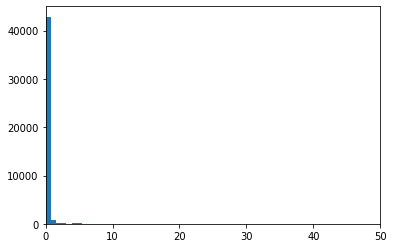

In [362]:
import matplotlib.pyplot as plt

# Distribution of number of interesting concepts per object
plt.hist(big_concept_object[useful_concepts].T.dot(np.ones(len(useful_concepts))), bins=1000)
plt.xlim(0, 50);

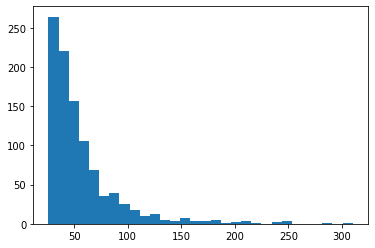

In [363]:
# Distribution of number of object per interesting concept 
plt.hist(big_concept_object[useful_concepts].dot(np.ones(big_concept_object.shape[1])), bins=30);

In [364]:
# an object and its concepts
i = np.random.choice(big_concept_object.shape[1])
#i = 34069
print(names[i], i)
print()
print('New method')
concepts = np.flatnonzero(big_concept_object[useful_concepts][:, i].toarray().ravel() * (length_concept[useful_concepts] >= 1))
#if len(concepts) > 10:
#    concepts = np.random.choice(concepts, size=20, replace=False)
for j in concepts:
    print(names_attribute[big_concept_attribute[useful_concepts][j].indices], j)
    
print()
print(f'old method')
concepts = np.flatnonzero(concept_object[:, i].toarray().ravel() * (length_concept > 1))

for j in concepts:
    print(names_attribute[concept_attribute[j].indices], concept_freq[j], j)

Painted Desert (Arizona) 30778

New method

old method
['color' 'red'] 195 26568


In [365]:
# Number of objects explained by 1 ore more concepts
len(np.flatnonzero(big_concept_object[useful_concepts].T.dot(np.ones(1000))))

2304

In [379]:
objects_idx_with_concepts = np.flatnonzero(big_concept_object[useful_concepts].T.dot(np.ones(1000)))
i = np.random.choice(objects_idx_with_concepts)

print(names[i], i)
print()
print('New method')
concepts = np.flatnonzero(big_concept_object[useful_concepts][:, i].toarray().ravel() * (length_concept[useful_concepts] >= 1))
#if len(concepts) > 10:
#    concepts = np.random.choice(concepts, size=20, replace=False)
for j in concepts:
    print(names_attribute[big_concept_attribute[useful_concepts][j].indices], j)
    
print()
print(f'old method')
concepts = np.flatnonzero(concept_object[:, i].toarray().ravel() * (length_concept > 1))

for j in concepts:
    print(names_attribute[concept_attribute[j].indices], concept_freq[j], j)

Eric Heiden 12682

New method
['Olympic' 'Games' 'athlete'] 237
['Olympic' 'Games'] 622
['Olympic' 'athlete'] 623
['Games' 'athlete'] 919

old method
['Olympics' 'Olympic'] 180 24330
['Olympics' 'Games'] 177 24331
['Olympics' 'gold'] 223 24333
['Olympics' 'athlete'] 141 24336
['Olympics' 'olympic'] 208 24337
['Olympics' 'medal'] 250 24340
['Olympics' 'Winter'] 119 24341
['Olympics' 'competition'] 112 24344
['Olympic' 'Games'] 244 24928
['Olympic' 'gold'] 147 24929
['Olympic' 'athlete'] 124 24930
['Olympic' 'olympic'] 157 24931
['Olympic' 'medal'] 159 24934
['Olympic' 'competition'] 102 24936
['Games' 'gold'] 136 25196
['Games' 'athlete'] 106 25197
['Games' 'olympic'] 134 25198
['Games' 'medal'] 152 25200
['Games' 'competition'] 103 25202
['gold' 'athlete'] 115 25921
['gold' 'olympic'] 232 25922
['gold' 'medal'] 316 25924
['speed' 'distance'] 111 26409
['athlete' 'olympic'] 149 26438
['athlete' 'medal'] 136 26440
['athlete' 'competition'] 85 26442
['olympic' 'medal'] 248 26669
['olympic

In [328]:
import networkx as nx

a = np.array([0, 1, 2])
dist = np.array([[0, 0.2, 0.7], [0.2, 0, 0.35], [0.7, 0.35, 0]])

tau = 2
adj = dist < tau
for i in range(adj.shape[0]):
    adj[i, i] = False
adj # edge when nodes are similar, i.e. distance between them is less than treshold
print(adj)

G = nx.from_numpy_array(adj)
nx.maximal_independent_set(G)

[[False  True  True]
 [ True False  True]
 [ True  True False]]


[1]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/simondelarue/Documents/PhD/Research/Envs/COMEG/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/hb/p2nvp7cj1dg6y96zlm9vqb2c0000gn/T/28330518902f48c1a35a57e49cff4555-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/hb/p2nvp7cj1dg6y96zlm9vqb2c0000gn/T/28330518902f48c1a35a57e49cff4555-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 6 COLUMNS
At line 19 RHS
At line 21 BOUNDS
At line 25 ENDATA
Problem MODEL has 1 rows, 3 columns and 3 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1.95 - 0.00 seconds
Cgl0004I processed model has 1 rows, 3 columns (3 integer (3 of which binary)) and 3 elements
Cutoff increment increased from 1e-05 to 0.04995
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -1.95


In [256]:
from pulp import LpVariable

class Solver():
    def __init__(self, concept_object, concept_attribute):
        self.concept_object = concept_object
        self.concept_attribute = concept_attribute
        self.concept_idx = np.arange(0, self.concept_object.shape[0])
        self.x = LpVariable.dicts("x", 
                                indices = self.concept_idx, 
                                lowBound=0, upBound=1, 
                                cat='Integer', indexStart=[])
        
    
    def init_variables(self):
        # (i) maximize the average of the word embeddings of each set, (ii) minimize the total pairwise cosine similarity
        #tfidf = TfIdf().fit_transform(self.concept_attribute)
        w2v = 
        return tfidf.shape
        
solver = Solver(concept_object.tolil(), concept_attribute)
res = solver.init_variables()
print(res)

(169956, 39777)


In [ ]:
class Solver():
    def __init__(self, concept_object, concept_attribute):
        self.concept_object = concept_object
        self.concept_attribute = concept_attribute
        self.concepts_idx = np.arange(0, self.concepts.shape[0])
        self.x = pulp.LpVariable.dicts("x", 
                                indices = self.concepts_idx, 
                                lowBound=0, upBound=1, 
                                cat='Integer', indexStart=[])
    
    def init_model_variables(self):

        tfidf = TfIdf().fit_transform(self.concept_attribute)
        for c in self.concepts:
            
            if metric == 'tf-idf':
                tfidf_val = 0
                gamma = 5
                idx_row = [self.lattice.context.G2idx.get(obj) for obj in c[0]]
                idx_col = [self.lattice.context.M2idx.get(attr) for attr in c[1]]
                tfidf_val = self.lattice.context.I[idx_row, :][:, idx_col].sum() # fc.filter_transform(method='tf-idf', k=100) needs to be called by user
                int_var.append(tfidf_val)
                ext_var.append(np.exp(-len(c[1])/gamma)) # size of intent is stored in ext_var 
                #ext_var.append(0) # size of intent is stored in ext_var 
                #print(f'ext: {np.exp(-len(c[1])/gamma):.3f} - int: {tfidf_val:.3f} - sum: {(np.exp(-len(c[1])/gamma)+tfidf_val):.3f} - {c}')

            else:
                int_var.append(len(c[1]) / n_unique_attr)
                # Size of graph induced by concept
                attr_idxs = [self.lattice.context.G2idx.get(i) for i in c[0]]
                g_concept = self.lattice.context.graph.adjacency_csr.T[attr_idxs]
                n_right, n_left = g_concept.shape
                m = g_concept.nnz
                ext_var.append((n_right + n_left + m) / self.lattice.context.graph.size())

        return ext_var, int_var
    
    def multi_obj_model(self, k: int = 5, metric: str = 'size'):
        """Build optmization multi-objective model with constraints, using weighted sum approach.

        Parameters
        ----------
        k : int, optional
            Number of concepts to select, by default 5
        metric : str
            * 'size': Size of extent and intent. Variables are:
                * Coverage of graph induced by the extent wrt the graph in the vicinity of the prediction
                * Ratio between size of the intent and number of unique attributes
            * 'tf-idf': Sum of `tf-idf` scores for each object-attribute pair

        Returns
        -------
        ``pulp`` problem object.
        """        
        # Variables are lengths of extent and intent of concepts
        ext_var, int_var = self.init_model_variables(metric=metric)
        
        # Find subset of 5 concepts that maximize both lengths of extents and intents
        step_size = 0.1
        solutionTable = pd.DataFrame(columns=["alpha", "obj_value"])
        min_obj = np.inf

        for alpha in np.arange(0, 1 + step_size, step_size):
            # Model definition
            prob = pulp.LpProblem("Best_concepts Multi objectives", LpMaximize)
            prob += alpha * pulp.lpSum([self.x[c] * ext_var[c] for c in self.concepts_idx]) \
                + (1 - alpha) * pulp.lpSum([self.x[c] * int_var[c] for c in self.concepts_idx])
            prob += pulp.lpSum([self.x[c] for c in self.concepts_idx]) == k
            if metric == 'size':
                for c in self.concepts_idx:
                    prob += self.x[c] * ext_var[c] <= 0.95
                    prob += self.x[c] * int_var[c] <= 0.95
            # Solving model
            solution = prob.solve(PULP_CBC_CMD(msg=False))
            solutionTable.loc[int(alpha*1/step_size)] = [alpha, pulp.value(prob.objective)]
            
            if pulp.value(prob.objective) <= min_obj:    
                min_obj = pulp.value(prob.objective)
                min_prob = prob

        # Plot Pareto frontier
        #fig, ax = plt.subplots(1, 1, figsize=(12, 7))
        #print(solutionTable)
        #plt.plot(solutionTable['alpha'], solutionTable['obj_value'], color='g')
        #plt.xlabel('alpha')
        #plt.ylabel('Objective value')
        #plt.show()
        # Save result img
        #PATH_RES = os.path.join(os.getcwd(), 'data', 'goodreads_poetry', 'result')
        #res = os.path.join(PATH_RES, 'img', f'LO_pareto_bc1d727746e210f315138932e0aacb11_13637887.eps')
        #plt.tight_layout()
        #plt.savefig(res)

        return min_prob
        
    def model(self, k: int = 5, metric: str = 'size'):
        """Build optmization model with objective and constraints.

        Parameters
        ----------
        k : int, optional
            Number of concepts to select, by default 5
        metric : str
            * 'size': Size of extent and intent
            * 'tf-idf': Sum of `tf-idf` scores for each object-attribute pair

        Returns
        -------
        ``pulp`` problem object.
        """        
        # Initialize variables to optimize according to metric
        ext_var, int_var = self.init_model_variables(metric=metric)

        # Find subset of 5 concepts that maximize variable
        prob = pulp.LpProblem("Best_concepts", LpMaximize)
        prob += pulp.lpSum([self.x[i] * (int_var[i] + ext_var[i]) for i in self.concepts_idx])
        prob += pulp.lpSum([self.x[i] for i in self.concepts_idx]) == k
        for i in self.concepts_idx:
            prob += self.x[i] * ext_var[i] <= 0.95
        
        return prob

    def solve(self, k: int = 5, metric: str = 'size', solver: object = PULP_CBC_CMD, msg: bool = False) -> list:
        """Solve optimization problem (default solver is CBC MILP).

        Parameters
        ----------
        k : int, optional
            Number of concepts to select, by default 5
        metric : str
            * 'size': Size of extent and intent
            * 'tf-idf': Sum of `tf-idf` scores for each object-attribute pair
        msg : bool, optional
            If `True`, print solver log in standard output, by default False

        Returns
        -------
        list
            List of concepts maximizing optimization problem.
        """        
        
        # Solve optimization
        if metric in ('size'):
            prob = self.multi_obj_model(k=k, metric=metric)
        elif metric == 'tf-idf':
            prob = self.model(k=k, metric=metric)
            prob.solve(solver(msg=msg))
        
        concept_idxs = np.array([int(v.name.split('_')[1]) for v in prob.variables() if v.varValue > 0])
        scores = np.array([v.dj for v in prob.variables()])

        return list(self.concepts[concept_idxs]), scores
